In [8]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt
what_were_covering = {1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [166]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [167]:

# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [168]:
import matplotlib.pyplot as plt
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data= X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

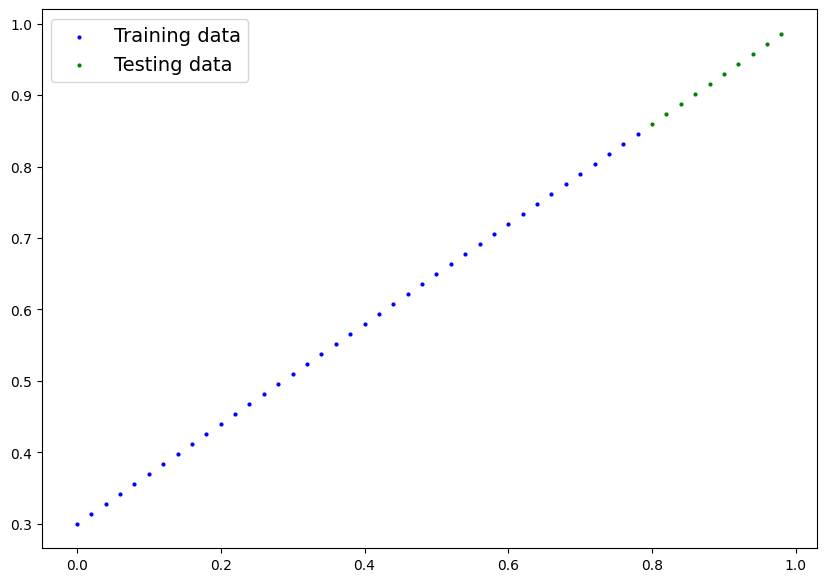

In [169]:
plot_predictions()


# Softmax by Baldesi 

 #### $ Softmax (x_i) = \frac{exp(x_i)}{\sum_j(x_j)}$  

 Applies the Softmax function to an n-dimensional input Tensor rescaling them so that the elements of the n-dimensional output Tensor lie in the range [0,1] and sum to 1.

 ref :https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html

 Input: 
(
∗
)
(∗) where * means, any number of additional dimensions

Output: 
(
∗
)
(∗), same shape as the input
$



In [170]:
m = nn.Softmax(dim=1)
input = torch.randn(2, 3)
output = m(input)
input

import torch.nn.functional as F
# def forward(self, x):
#         b = F.softmax(x, dim=1) * F.log_softmax(x, dim=1)
#         b = -1.0 * b.sum()
#         return b 


In [171]:
output

tensor([[0.4438, 0.4420, 0.1142],
        [0.0794, 0.8701, 0.0505]])

In [172]:
class LinearRegressionModel(nn.Module): # <- Almost anything in Pytorch inherhits from nn.Module

    def __init__(self) -> None:
        super().__init__()
        # Initialize model parameters
        self.weights = nn.Parameter(torch.randn(1, requires_grad= True, dtype = torch.float))

        self.bias = nn.Parameter(torch.randn(1, requires_grad= True, dtype = torch.float))

#Forward method to define the computation in the model

    def forward(self, x:torch.Tensor) -> torch.Tensor : # <-"x" is the input data ( training data)

        return self.weights *x + self.bias #this is the linear regression formula


""" 
What our model does :
Start with random values ( weight & bias)
Look at training data and adjust the random values to better represent ( or get closser to) ideia values

Through two main algorithms

1. Gradient descent  --> requires_grad= True
2. Backpropagation
"""


' \nWhat our model does :\nStart with random values ( weight & bias)\nLook at training data and adjust the random values to better represent ( or get closser to) ideia values\n\nThrough two main algorithms\n\n1. Gradient descent  --> requires_grad= True\n2. Backpropagation\n'

In [231]:
nn.Parameter(torch.rand(1, requires_grad= True , dtype= torch.float))

Parameter containing:
tensor([0.5936], requires_grad=True)

In [173]:

import torch
import torch.nn as nn


class GamblerLoss(nn.Module):
    def __init__(self, inference_will=1.1):
        super().__init__()
        """ Returns a CrossEntropyLoss-like object that has been modified
            according to the DeepGambler paper [1].
        Parameters
        ----------
        inference_will: floating point
            The willingness to infer or abstain.  Greater values make the
            inference more confident, while lower values make abstention more
            likely.  Given m different classes (not inclusive of the abstention
            class), meaningful values are in the range (1, m).
        Notes
        -----
        [1] DeepGamblers: Learning to Abstain with Portfolio Theory. L. Ziyin,
            Z. T. Wang, P. Pu Liang, R. Salakhutdinov, L.P. Morency, M. Ueda.
            NeurIPS, 2019
        """

        self.o = torch.tensor(inference_will)
        self.nllloss = nn.NLLLoss()
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, v, labels):
        """ Returns the Gambler loss value
        Parameters
        ----------
        v: a tensor of inputs with dimension BxI
        labels: a tensor with dimension Bx1 of indexes in [0, I-2] of the
                correct label (the I-1-th class is the abstinence one and
                should not be used in training).
        Notes
        -----
        This loss is a Negative Log Likelihood of weighted and scaled
        probabilities (from the Softmax response).  We refer to the log of
        these values as log_gambler_values.
        """

        x = self.log_gambler_values(v)
        return self.nllloss(x, labels)

    def log_gambler_values(self, v):
        """ Returns the log values to be passed to the Negative Log Likelihood
            Loss.
        Parameters
        ----------
        v: a tensor of inputs with dimension BxI
        Notes
        -----
        In order to avoid overflow issues due to exp of a large number, we
        execute it only on arguments lower or equal than 0. In order to avoid
        instability issues due to log of a small number, we execute it only on
        arguments greater or equal than 1.
        Our target values are in the form:
            xi = log (fi*o + fm)
        where fi = exp(vi)/sum(exp(vj)).
        To avoid computing exponential with argument greater than 0 we rescale
        the values wrt. the maximum per the first dimension, indicated as V.
        => fi = exp(vi-V)/sum(exp(vj-V)).
        xi = log[o*exp(vi-V)/sum(exp(vj-V)) + exp(vm-V)/sum(exp(vj-V))]
        vm is the value of the m+1-th class, the abstinence class.
        xi = log[(o*exp(vi-V) + exp(vm-V))/sum(exp(vj-V))]
           = log[o*exp(vi-V)(1 + exp(vm-V)/(exp(vi-V)*o)] - log(sum(exp(vj-V))
           = vi - V + log(o + exp(vm-V)/exp(vi-V)) - log(sum(exp(vj-V))
           = log(o + exp(vm-V)/exp(vi-V)) + log_softmax(v)
        The two exponential must be computed separately as there is no
        guarantee that vm-vi<=0. Being the exponentials greater than 0 and o
        >= 1, it follows the stability constraints are respected.
        """
        maxs = v.max(dim=1)[0]
        lasts = v[:,-1]

        upper = torch.exp(lasts-maxs)
        upside = torch.exp(v.transpose(0, 1).add(-maxs)).div(upper).transpose(0, 1)
        x = 1./upside + self.o
        return self.log_softmax(v) + torch.log(x)


def log_gambler(v, o):
    """
    dummy implementation for testing
    """
    softmax = nn.Softmax(dim=1)
    x = softmax(v)
    z = x[:, -1]
    y = torch.mul(x, o)
    x = y+z.unsqueeze(1)

    x = torch.log(x)  ## could be numerically unstable if probabilities approach zero
    return x


def output2class(model_output, coverage, abstain_class):
    probs = torch.softmax(model_output, dim=1)[:, abstain_class]
    _, predicted = torch.max(model_output[:, :abstain_class], dim=1)
    predicted = (probs < coverage).int().mul(predicted)
    predicted += (probs >= coverage).int().mul(abstain_class)
    return predicted


if __name__ == "__main__":
    v = torch.tensor([[1, 2, 3], [6, 4, 5]], dtype=float)
    o = 1.5
    gl = GamblerLoss(o)

    y = gl.log_gambler_values(v)
    z = log_gambler(v, o)

    print(f"Expected {z}")
    print(f"Computed {y}")


Expected tensor([[-0.2228,  0.0318,  0.5087],
        [ 0.2172, -0.9682, -0.4913]], dtype=torch.float64)
Computed tensor([[-0.2228,  0.0318,  0.5087],
        [ 0.2172, -0.9682, -0.4913]], dtype=torch.float64)


In [174]:
x = torch.tensor([[1, 2, 3, 4,5], [1, 2, 3, 4,5]] )
torch.unsqueeze(x,2)

tensor([[[1],
         [2],
         [3],
         [4],
         [5]],

        [[1],
         [2],
         [3],
         [4],
         [5]]])

In [175]:
torch.unsqueeze(x,1).shape

torch.Size([2, 1, 5])

In [176]:
torch.manual_seed(42)
model = LinearRegressionModel()
list(model.__dict__)

['training',
 '_parameters',
 '_buffers',
 '_non_persistent_buffers_set',
 '_backward_pre_hooks',
 '_backward_hooks',
 '_is_full_backward_hook',
 '_forward_hooks',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_state_dict_hooks',
 '_state_dict_pre_hooks',
 '_load_state_dict_pre_hooks',
 '_load_state_dict_post_hooks',
 '_modules']

In [177]:
model.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [178]:
X_test ,y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [179]:
# make predictions with model

with torch.inference_mode():
    y_preds = model(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

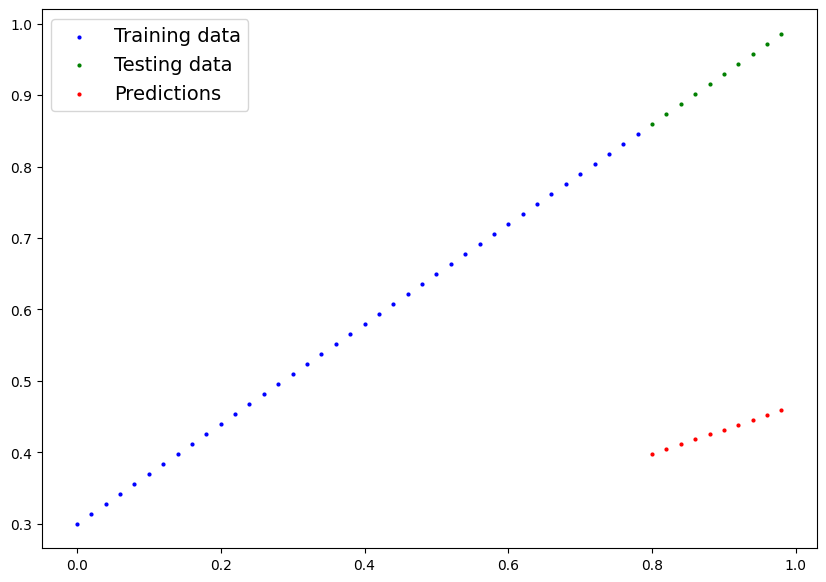

In [180]:
plot_predictions(predictions= y_preds)


### Train model¶
Right now our model is making predictions using random parameters to make calculations, it's basically guessing (randomly).

To fix that, we can update its internal parameters (I also refer to parameters as patterns), the weights and bias values we set randomly using nn.Parameter() and torch.randn() to be something that better represents the data.

We could hard code this (since we know the default values weight=0.7 and bias=0.3) .

The whole idea of training is for a model to move from somu unknown parameters to some knows parameers.

Things we need to train ?

**Loss function**: A function to measure how wrong your model predictions are to the ideal outputs.
**Optimize** : Takes into account the loss of a model and adjusts the model's parameters to improve the loss functions 
  >  Inside the optimizer , you often have to set two parameters : >

params - the model parameters you like to optimize, for example  params = model.parameters()
lr - ( learning rate )- the learning rate is a hyperparameter that defines how big/small the optimizer changes the parameters with each step ( a small lr results in small changes, a large lr results in large changes )

for Pytorch, we need : 

 - A training loop
 - A testing loop

 **Loss function** => Mean absolute error (MAE) for regression problems (torch.nn.L1Loss()). Binary cross entropy for binary classification problems (torch.nn.BCELoss()). PyTorch has plenty of built-in loss functions in torch.nn

 **Optimizer** =Stochastic gradient descent (torch.optim.SGD()). Adam optimizer (torch.optim.Adam()).
 , You can find various optimization function implementations in torch.optim.

 -- set learning rate scheduling
    

In [181]:
# Setup a loss function

loss_fn = nn.L1Loss(reduction='mean')


#Setup an optimizer ( stochastis gradient descent)

optimizer = torch.optim.SGD(params= model.parameters(), lr = 0.01)
# lr = learning rate = the smaller the lr,  small the changes on the parameters, the greater the lr, greater the changes


In [182]:
loss_fn.__dict__

{'training': True,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_pre_hooks': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_hooks_with_kwargs': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_forward_pre_hooks_with_kwargs': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict(),
 'reduction': 'mean'}

In [183]:
list(model.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

### Building a training loop ( and a testing loop ) in PyTorch
 - Loop through the data
 - Forward pass ( this involves data moving through our model' forward () function ) to make predicition on data = also called forward propagation
 - Calculate the loss ( compare forward pass predicition to ground truth labels)4 - Loss backward - move backwards through the network to calculate the gradientes of each of the parameters of our model with to the loss (**backpropagation**)
 - Optimizer  step - use the optimize to adjust our odel parameters to try and improve the loss (**gradient descent**)

In [187]:
# An epoch is one loop throught the data

epochs = 100
# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

### TRAINING
for epoch in range(epochs):
    model.train()  #train mode in PyTorch sets al parametrs that requires gardients

    #1. Forwards pass on train data using forward() method inside
    y_pred = model(X_train)

    #2. Calculate the loss ( how wrong the model prediction are)
    loss = loss_fn(y_pred, y_train)
    

    #3. Optimizer zero grad
    #Zero the optimizer gradientes ( they accumulate every epoch, zero them to start fresh each forward pass)
    optimizer.zero_grad()

    # 4. Perform backpropagation on the loss with respect to the parameters of the model
    # compute the gradient of every parameter with requires_grad = True
    loss.backward()
    
    #5. Step the optimizer ( perform gradient descent)
    optimizer.step() # Its update our model parameters to try get them further close our original parameters
   # equaly to loss close to zero

    # Testing 
    model.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.3013603389263153 | MAE Test Loss: 0.4675942063331604 
Epoch: 10 | MAE Train Loss: 0.18615034222602844 | MAE Test Loss: 0.3328842222690582 
Epoch: 20 | MAE Train Loss: 0.08227583020925522 | MAE Test Loss: 0.2069590985774994 
Epoch: 30 | MAE Train Loss: 0.05181945487856865 | MAE Test Loss: 0.14023718237876892 
Epoch: 40 | MAE Train Loss: 0.04503796249628067 | MAE Test Loss: 0.11182951927185059 
Epoch: 50 | MAE Train Loss: 0.04132963344454765 | MAE Test Loss: 0.09809747338294983 
Epoch: 60 | MAE Train Loss: 0.03785243630409241 | MAE Test Loss: 0.08776430785655975 
Epoch: 70 | MAE Train Loss: 0.03441363573074341 | MAE Test Loss: 0.0794917643070221 
Epoch: 80 | MAE Train Loss: 0.030979642644524574 | MAE Test Loss: 0.07190609723329544 
Epoch: 90 | MAE Train Loss: 0.02754882536828518 | MAE Test Loss: 0.06363357603549957 


In [ ]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w, b = params
        t_p = model(t_u, w, b)
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)
        params = params - learning_rate * grad
        print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params


training_loop(
 n_epochs = 100,
 learning_rate = 1e-2,
 params = torch.tensor([1.0, 0.0]),
 t_u = t_u,
 t_c = t_c)

In [188]:
model.state_dict()

OrderedDict([('weights', tensor([0.5800])), ('bias', tensor([0.3503]))])

In [189]:
weight, bias

(0.7, 0.3)

In machine learning , a gradiente is a derivative of function that has more than one input variable.
Know as slope of a fucntions in mathematical terms. The gradients simply measures the change in all wieghts with regard to the change in error

In [190]:
with torch.inference_mode():
    y_pred_new = model(X_test)

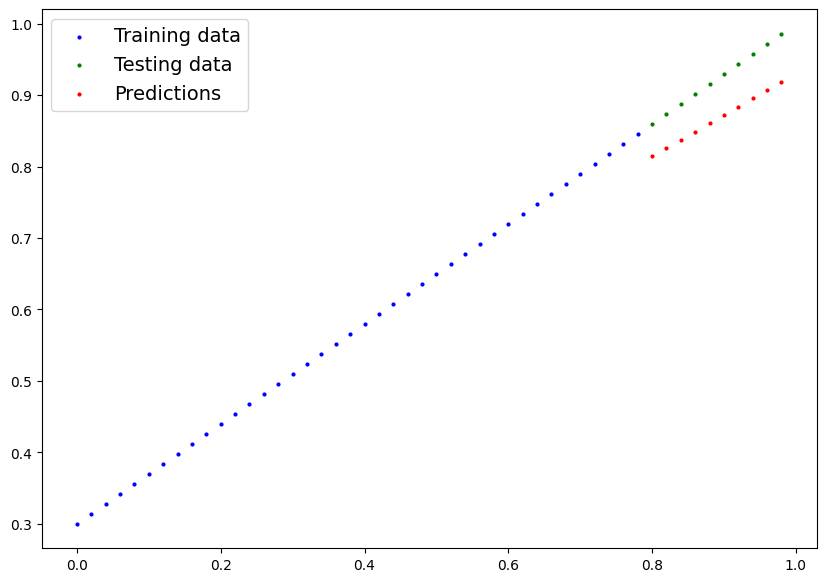

In [191]:
plot_predictions(predictions=y_pred_new)

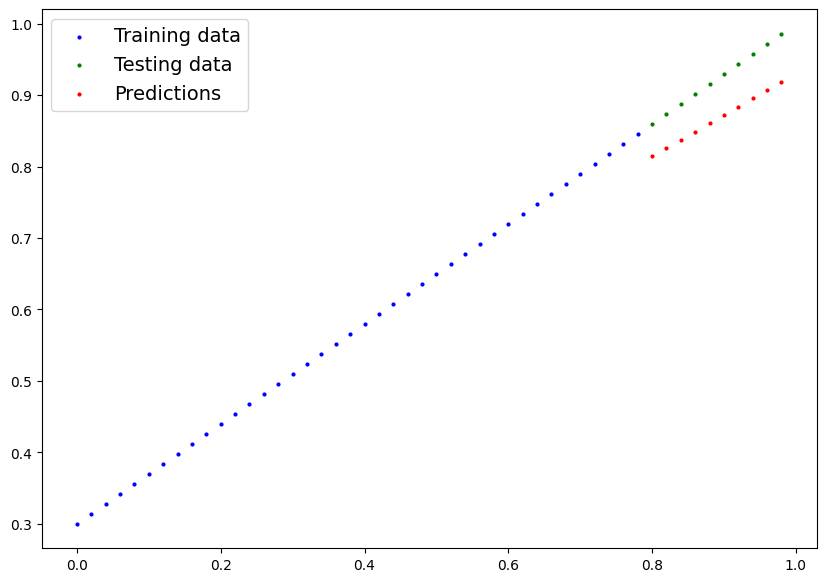

In [192]:
plot_predictions(predictions=test_pred)

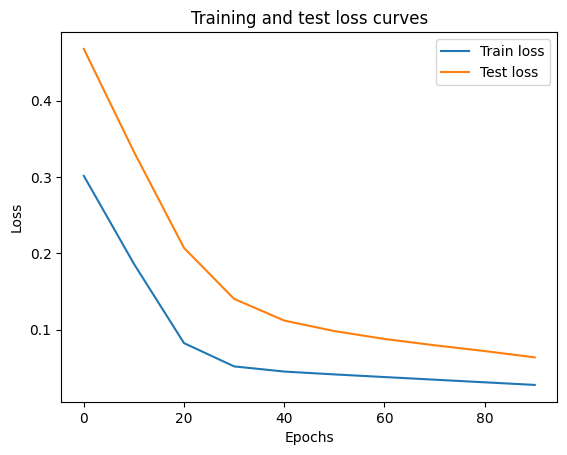

In [193]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

### Saving model in PyTorch

There are three main method aobut saving and loading models in PyTorch

* `torch.save()` - allows you save a PyTorch object in Python's pickle format
* `torch.load()` - allows you load a saved PyTorch object
* `torch.nn.Module.load_state_dict()` - this allows to load a model saved state dictionary

In [195]:
from pathlib import Path

# 1 Create models directory
MODEL_PATH = Path("Models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#2 Create model save path

MODEL_NAME = "PyTorch_LinearRegression.pth"
MODEL_SAVE_PATH = MODEL_PATH /MODEL_NAME

# JUST BY RUN MODEL_SAVE_PATH, CREATE THE MODEL DIRECTORY

# Save the model state dict
torch.save(obj = model.state_dict(), f = MODEL_SAVE_PATH)

In [196]:
# Loading a PyTorch model

loaded_model = LinearRegressionModel()


loaded_model.load_state_dict(torch.load(f = MODEL_SAVE_PATH))


<All keys matched successfully>

In [198]:
loaded_model.state_dict()

OrderedDict([('weights', tensor([0.5800])), ('bias', tensor([0.3503]))])

In [201]:
# 1. Put the loaded model into evaluation mode
loaded_model.eval()
model.eval()

with torch.inference_mode():
    y_preds = model(X_test)

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model(X_test) 
    
loaded_model_preds# perform a forward pass on the test data with the loaded model

tensor([[0.8143],
        [0.8259],
        [0.8375],
        [0.8491],
        [0.8607],
        [0.8723],
        [0.8839],
        [0.8955],
        [0.9071],
        [0.9187]])

In [205]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

### 6. Putting it all together

Except this time we'll make our code device agnostic (so if there's a GPU available, it'll use it and if not, it will default to the CPU).

There'll be far less commentary in this section than above since what we're going to go through has already been covered.

We'll start by importing the standard libraries we need.

Note: If you're using Google Colab, to setup a GPU, go to Runtime -> Change runtime type -> Hardware acceleration -> GPU. If you do this, it will reset the Colab runtime and you will lose saved variab

In [206]:
# Import PyTorch and matplotlib
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [207]:
# Create weight and bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will happen later on (shapes within linear layers)
y = weight * X + bias 
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [208]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

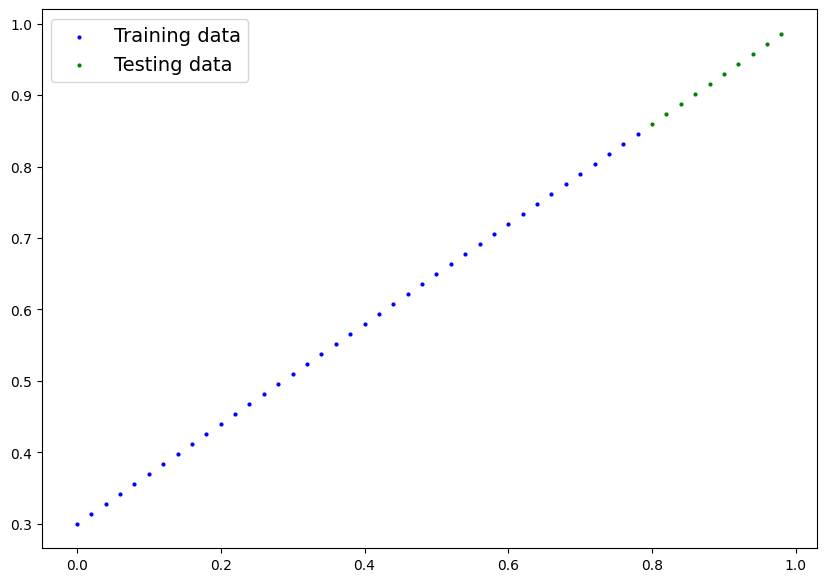

In [209]:
# Note: If you've reset your runtime, this function won't work, 
# you'll have to rerun the cell above where it's instantiated.
plot_predictions(X_train, y_train, X_test, y_test)

In [210]:
# Subclass nn.Module to make our model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1, 
                                      out_features=1)
    
    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed when creating the model (this isn't always need but is used for demonstrative purposes, try commenting it out and seeing what happens)
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [211]:
# Check model device
next(model_1.parameters()).device

device(type='cpu')

In [212]:
# Set model to GPU if it's availalble, otherwise it'll default to CPU
model_1.to(device) # the device variable was set above to be "cuda" if available or "cpu" if not
next(model_1.parameters()).device

device(type='cpu')

 * Forward pass - The model goes through all of the training data once, performing its forward() function calculations (model(x_train)). 

* Calculate the loss - The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are (loss = loss_fn(y_pred, y_train).

* Zero gradients - The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step (optimizer.zero_grad()).

* Perform backpropagation on the loss - Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with requires_grad=True). This is known as backpropagation, hence "backwards" (loss.backward()).

* Step the optimizer (gradient descent) - Update the parameters with requires_grad=True with respect to the loss gradients in order to improve them (optimizer.step()). 

In [215]:
# Create loss function
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), # optimize newly created model's parameters
                            lr=0.01)

In [216]:
torch.manual_seed(42)

# Set the number of epochs 
epochs = 1000 

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_1.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_1(X_test)
    
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 100 | Train loss: 0.006215679459273815 | Test loss: 0.014086711220443249
Epoch: 200 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 300 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 400 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 500 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 600 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 700 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 800 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904
Epoch: 900 | Train loss: 0.0012645035749301314 | Test loss: 0.013801807537674904


In [217]:
# Find our model's learned parameters
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html 
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


In [218]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]])

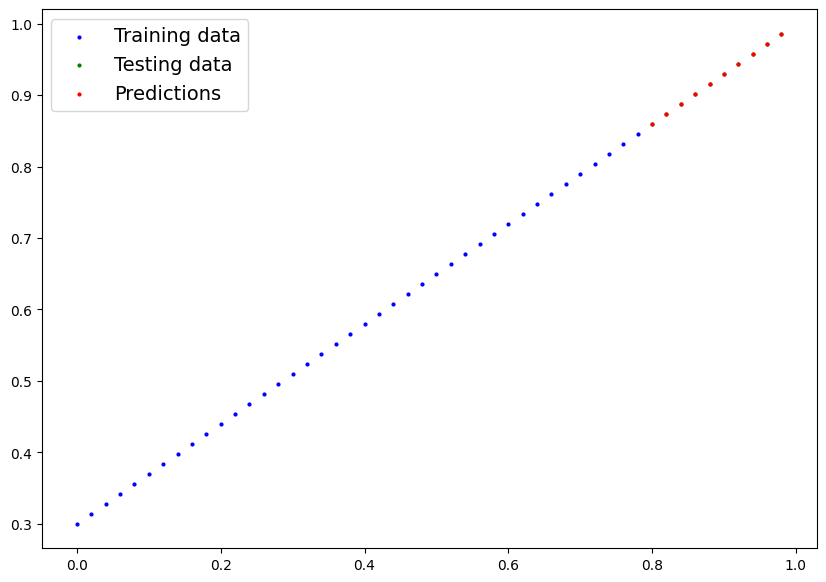

In [219]:
# plot_predictions(predictions=y_preds) # -> won't work... data not on CPU

# Put data on the CPU and plot it
plot_predictions(predictions=y_preds.cpu())

In [ ]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

In [ ]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# Load model state dict 
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

In [ ]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds